In [85]:
# install seaborn library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# if you need to install some packages, use this command
#!pip install tensorflow

In [86]:
# read the csv file 
salary_df = pd.read_csv('salary.csv')
salary_df.head(5)
salary_df.tail(5)

,YearsExperience,Salary
30,11.2,127345
31,11.5,126756
32,12.3,128765
33,12.9,135675
34,13.5,139465


In [87]:
#get some information about our DataSet
salary_df.info()
salary_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  35 non-null     float64
 1   Salary           35 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 688.0 bytes


,YearsExperience,Salary
count,35.000000,35.000000
mean,6.308571,83945.600000
std,3.618610,32162.673003
min,1.100000,37731.000000
25%,3.450000,57019.000000
50%,5.300000,81363.000000
75%,9.250000,113223.500000
max,13.500000,139465.000000


In [88]:
# check if there are any Null values
salary_df.isnull().sum()

YearsExperience    0
Salary             0
dtype: int64

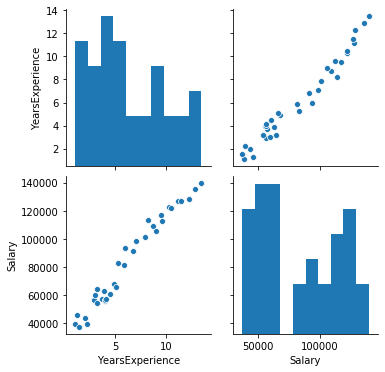

In [89]:
#visualizing data
sns.pairplot(salary_df)


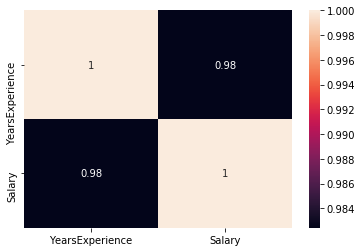

In [73]:
sns.heatmap(salary_df.corr(), annot=True)

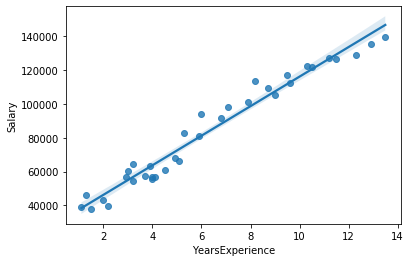

In [74]:
sns.regplot(salary_df['YearsExperience'], salary_df['Salary'], data = salary_df )

In [90]:
#define X variables and our target(y)
X = salary_df[['YearsExperience']]
y = salary_df[['Salary']]

X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [91]:
y_train = y_train[:,0]


In [92]:
y_test = y_test[:,0]

In [93]:
#import required kits
import sagemaker
import boto3
#create a Sagemaker session
sagemaker_session = sagemaker.Session()
#define the S3 bucket and prefix(subfolder within the bucket)
bucket = 'sagemaker-practical-m'
prefix = 'linear-learner' 
#define IAM role
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::329355616934:role/service-role/AmazonSageMaker-ExecutionRole-20200701T203690


In [94]:
#import module in terms of dealing with various types of I/O
import io
#import sagemaker common library
import sagemaker.amazon.common as smac 
#converts the data in numpy array format to RecordIO format
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)

#reset in-memory byte arrays to zero
buf.seek(0)

0

In [95]:
import os
 
# Key refers to the name of the file    
key = 'linear-train-data'

#uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

#training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-practical-m/linear-learner/train/linear-train-data


In [96]:
y_test.shape

(12,)

In [97]:
# create an output location in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-practical-m/linear-learner/output


In [98]:
#specify the name of the algorithm, that we want to use

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [105]:
#We pass to the container and the type of instance that we like to use for training
# moreover output path and sagemaker session into the Estimator are provided.

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)




# We can tune parameters such as:
#number of features passing in
#type of predictor ('regressor' or 'classifier')
#mini batch size (the number of observations per mini-batch)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

#pass in the training data from S3 to train the linear learner model
linear.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

2020-07-12 19:22:48 Starting - Starting the training job...
2020-07-12 19:22:50 Starting - Launching requested ML instances......
2020-07-12 19:24:05 Starting - Preparing the instances for training......
2020-07-12 19:25:19 Downloading - Downloading input data...
2020-07-12 19:25:41 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/12/2020 19:26:05 INFO 139869235312448] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'in

In [106]:
# Deploying the model to perform inference 

linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

-------------!

In [107]:
from sagemaker.predictor import csv_serializer, json_deserializer


linear_regressor.content_type = 'text/csv'
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

In [108]:
# making prediction on the test data
result = linear_regressor.predict(X_test)

In [109]:
# results are in Json format
result 

{'predictions': [{'score': 112013.7734375},
  {'score': 85669.53125},
  {'score': 73565.421875},
  {'score': 110589.7578125},
  {'score': 93501.609375},
  {'score': 72141.40625},
  {'score': 65021.34375},
  {'score': 47933.19140625},
  {'score': 65733.3515625},
  {'score': 105605.71875},
  {'score': 101333.671875},
  {'score': 133373.96875}]}

In [111]:
# we access the scores by iterating through the scores in the predictions
predictions = np.array([r['score'] for r in result['predictions']])
predictions

array([112013.7734375 ,  85669.53125   ,  73565.421875  , 110589.7578125 ,
        93501.609375  ,  72141.40625   ,  65021.34375   ,  47933.19140625,
        65733.3515625 , 105605.71875   , 101333.671875  , 133373.96875   ])

Text(0.5, 1.0, 'Salary vs. Years of Experience')

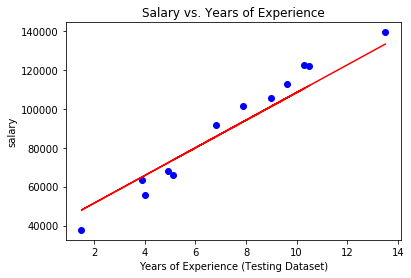

In [113]:
# test set result visualization
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Years of Experience (Testing Dataset)')
plt.ylabel('salary')
plt.title('Salary vs. Years of Experience')

In [115]:
#compare actual output values with predicted values
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
df

,Actual,Predicted
0,121872.0,112013.773438
1,91738.0,85669.531250
2,66029.0,73565.421875
3,122391.0,110589.757812
4,101302.0,93501.609375
5,67938.0,72141.406250
6,63218.0,65021.343750
7,37731.0,47933.191406
8,55794.0,65733.351562
9,112635.0,105605.718750


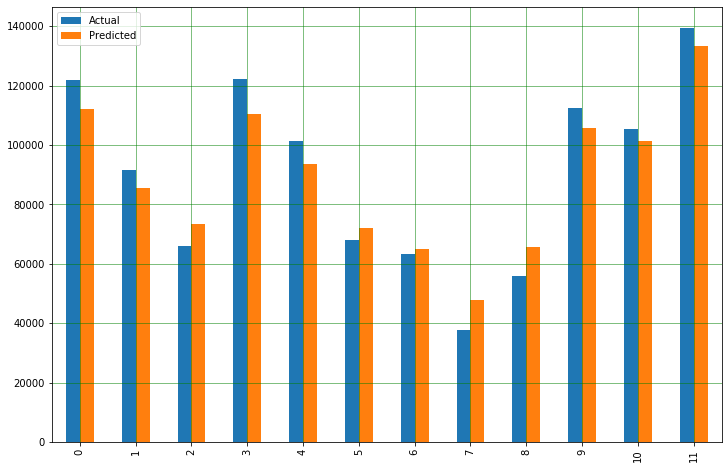

In [120]:
# visualize comparison result as a bar graph
df1 = df.head(20)
df1.plot(kind='bar',figsize=(12,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

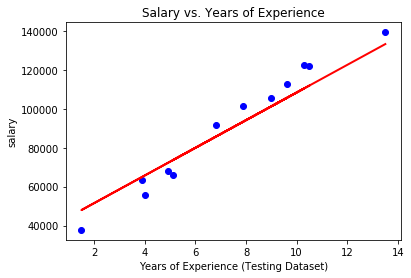

In [121]:
#prediction vs test set
plt.scatter(X_test, y_test,  color='blue')
plt.plot(X_test, predictions, color='red', linewidth=2)
plt.xlabel('Years of Experience (Testing Dataset)')
plt.ylabel('salary')
plt.title('Salary vs. Years of Experience')
plt.show()



In [ ]:
# Delete the end-point

linear_regressor.delete_endpoint()